Building models...


Training CNN...
Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.4261 - loss: 1.3714 - val_accuracy: 0.1000 - val_loss: 1.5899 - learning_rate: 0.0010
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7004 - loss: 0.8459 - val_accuracy: 0.2733 - val_loss: 1.5362 - learning_rate: 0.0010
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7411 - loss: 0.6880 - val_accuracy: 0.2000 - val_loss: 1.5696 - learning_rate: 0.0010
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7765 - loss: 0.6094 - val_accuracy: 0.2000 - val_loss: 1.8548 - learning_rate: 0.0010
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7862 - loss: 0.5582 - val_accuracy: 0.2000 - val_loss: 2.1990 - learning_rate: 0.0010
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8105 - loss: 0.5070 - val_accuracy: 0.2000 - val_loss: 2.6693 - learning_rate: 0.0010
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accu

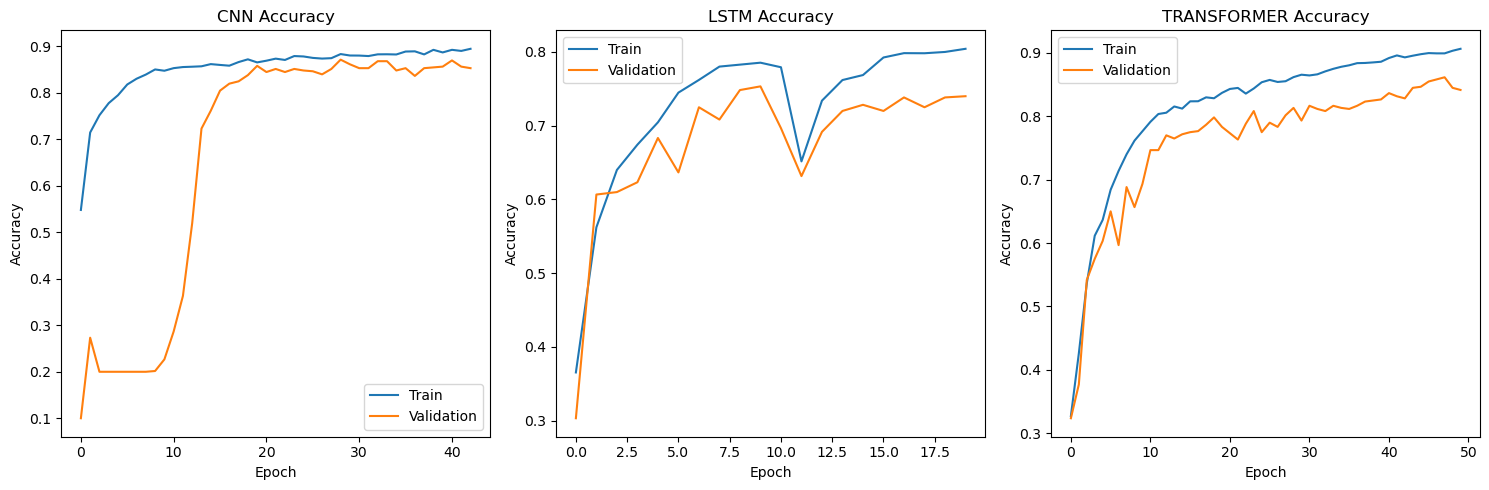

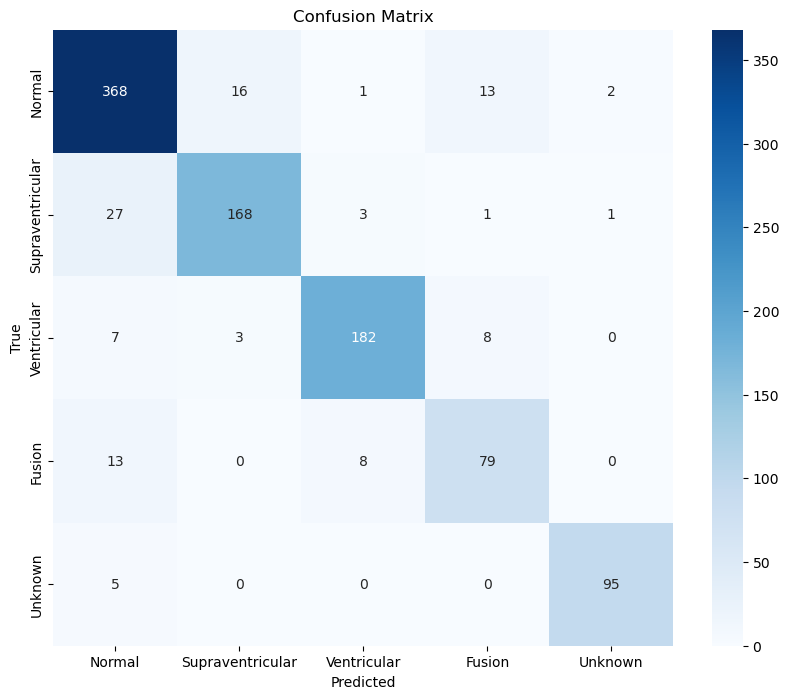

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


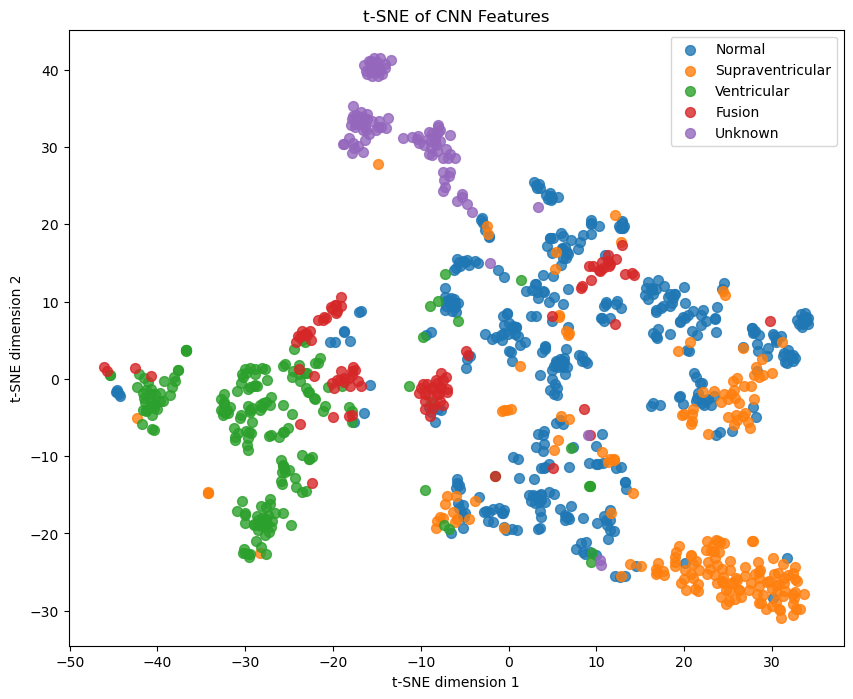

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.signal import butter, filtfilt

# Configuration
DATA_DIR = "mit_bih"
SAMPLE_LENGTH = 200
CLASS_NAMES = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']
AAMI_MAP = {'N':0, 'L':0, 'R':0, 'A':1, 'a':1, 'J':1, 'S':1, 
            'V':2, 'E':2, 'F':3, '/':4, 'f':4, 'Q':4}

def butter_bandpass_filter(data, lowcut=0.5, highcut=45.0, fs=360, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def load_and_preprocess():
    """Load and preprocess MIT-BIH data with advanced filtering"""
    records = [f.split('.')[0] for f in os.listdir(DATA_DIR) if f.endswith('.hea')]
    signals, labels = [], []
    
    for rec in records:
        try:
            record = wfdb.rdrecord(os.path.join(DATA_DIR, rec), channels=[0])
            ann = wfdb.rdann(os.path.join(DATA_DIR, rec), 'atr')
            
            # Advanced filtering
            signal = butter_bandpass_filter(record.p_signal.flatten())
            
            for idx, symbol in zip(ann.sample, ann.symbol):
                if (SAMPLE_LENGTH//2 < idx < len(signal)-SAMPLE_LENGTH//2) and (symbol in AAMI_MAP):
                    segment = signal[idx-SAMPLE_LENGTH//2 : idx+SAMPLE_LENGTH//2]
                    segment = (segment - np.mean(segment)) / (np.std(segment) + 1e-7)
                    signals.append(segment)
                    labels.append(AAMI_MAP[symbol])
        except Exception as e:
            print(f"Error processing {rec}: {str(e)}")
            continue
    
    return np.array(signals), np.array(labels)

# Add the Keras serialization decorator to make the custom layer serializable
@tf.keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(embed_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)
    
    # Add get_config and from_config methods for serialization
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
        })
        return config

def build_cnn():
    """Build CNN model using Functional API to avoid input issues"""
    inputs = layers.Input(shape=(200,))
    x = layers.Reshape((200, 1))(inputs)
    x = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm():
    """Build LSTM model using Functional API to avoid input issues"""
    inputs = layers.Input(shape=(200,))
    x = layers.Reshape((200, 1))(inputs)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.LSTM(32)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_transformer():
    """Build transformer model with Functional API (already implemented correctly)"""
    inputs = layers.Input(shape=(200,))
    x = layers.Reshape((200, 1))(inputs)
    x = layers.Conv1D(32, 3, padding='same')(x)
    x = TransformerBlock(32, 4)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Ensemble prediction function
def ensemble_predict(models_list, X_data):
    """
    Get ensemble predictions from multiple models
    
    Args:
        models_list: List of trained models
        X_data: Input data
        
    Returns:
        Ensemble predictions
    """
    # Collect predictions from each model
    all_preds = []
    for model in models_list:
        y_pred = model.predict(X_data)
        all_preds.append(y_pred)
    
    # Average the predictions
    ensemble_preds = np.mean(all_preds, axis=0)
    return ensemble_preds

def train_and_evaluate():
    X, y = load_and_preprocess()
    
    # Class balancing
    rus = RandomUnderSampler(sampling_strategy={0:2000, 1:1000, 2:1000, 3:500, 4:500})
    X_reshaped = X.reshape(X.shape[0], -1)
    X_balanced, y_balanced = rus.fit_resample(X_reshaped, y)
    X_balanced = X_balanced.reshape(-1, SAMPLE_LENGTH)
    
    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
    )
    
    # Apply SMOTE
    sm = SMOTE()
    X_train, y_train = sm.fit_resample(X_train.reshape(len(X_train), -1), y_train)
    X_train = X_train.reshape(-1, SAMPLE_LENGTH)
    
    # Initialize models
    print("Building models...")
    model_dict = {
        'cnn': build_cnn(),
        'lstm': build_lstm(),
        'transformer': build_transformer()
    }
    
    # Train individual models
    histories = []
    trained_models = []
    
    for name, model in model_dict.items():
        print(f"\nTraining {name.upper()}...")
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=128,
            callbacks=[
                callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(factor=0.2, patience=5)
            ],
            verbose=1
        )
        model.save(f'{name}_model.keras')
        trained_models.append(model)
        histories.append(history)
        print(f"{name.upper()} training completed")
    
    # Evaluate each model individually
    print("\nIndividual Model Performance:")
    for name, model in zip(model_dict.keys(), trained_models):
        y_pred = np.argmax(model.predict(X_test), axis=1)
        print(f"\n{name.upper()} Performance:")
        print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))
    
    # Get ensemble predictions
    print("\nGenerating ensemble predictions...")
    ensemble_predictions = ensemble_predict(trained_models, X_test)
    y_pred = np.argmax(ensemble_predictions, axis=1)
    
    print("\nFinal Ensemble Performance:")
    print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))
    
    # Visualizations
    plt.figure(figsize=(15, 5))
    for i, (name, history) in enumerate(zip(model_dict.keys(), histories)):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.title(f'{name.upper()} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Extract features for visualization
    # Create a feature extraction model from the CNN model
    feature_model = models.Model(
        inputs=model_dict['cnn'].input,
        outputs=model_dict['cnn'].layers[-2].output
    )
    
    # Extract features
    features = feature_model.predict(X_test)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(features)
    
    # Plot t-SNE visualization
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(CLASS_NAMES):
        plt.scatter(
            reduced[y_test == i, 0], reduced[y_test == i, 1],
            label=class_name, alpha=0.8, s=50
        )
    plt.title('t-SNE of CNN Features')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.legend()
    plt.savefig('tsne_visualization.png')
    plt.show()

if __name__ == "__main__":
    train_and_evaluate()